In [1]:
# Magic line to avoid explicitely write plt.show()
%matplotlib inline

In [2]:
#do not show warnings
import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis (EDA)
This notebook will detail an exploratory data analysis of the sales dataset which will feed the forecasting model:
- As well, this will provide a quick way to check the generated/simulated data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
sales_clusters_df=pd.read_csv('../data/raw/sales_cluster_table.csv')

In [5]:
sales_clusters_df.Cluster.value_counts()

3    148
4     78
0     32
1     17
2      4
Name: Cluster, dtype: int64

In [6]:
sales_clusters_df.head()

,product_code,noisy_date,noisy_quantity,Cluster
0,CLA0,2017-12-28,5038.619159,0
1,CLA0,2018-03-11,4658.195181,0
2,CLA0,2018-05-18,4676.433462,0
3,CLA0,2018-07-25,5067.550234,0
4,CLA0,2018-10-04,4602.628398,0


In [7]:
sales_clusters_df['noisy_date']=pd.to_datetime(sales_clusters_df['noisy_date'])

In [8]:
sales_clusters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 4 columns):
product_code      279 non-null object
noisy_date        279 non-null datetime64[ns]
noisy_quantity    279 non-null float64
Cluster           279 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 8.8+ KB


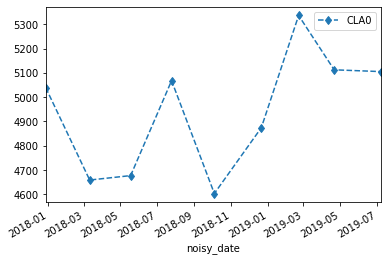

In [9]:
sales_clusters_df[sales_clusters_df.product_code=='CLA0'][['noisy_date','noisy_quantity']]\
.plot.line(x='noisy_date',y='noisy_quantity',linestyle='--',marker='d')
plt.legend(['CLA0'])

# Just a small prophet model to try the library

- I then realise we need to build a model to predict the next sale date and then the next sale quantity

In [10]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py
import plotly.graph_objs as go

## First model to predict next sale date

In [11]:
train_year='2018'
test_year='2019'

In [12]:
def generate_next_sale_column(df):
    df['next_sale_date']=df['noisy_date'].shift(-1)
    df.drop([len(df)-1],inplace=True)
    
    # y will be the number of days until the next sale
    df['y']=(df['next_sale_date']-df['noisy_date']).dt.days.astype(int)
    
    return df

In [13]:
def plot_date_preds(date_forecast,product,idx_split):
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=date_forecast['ds'],
                             y=date_forecast['actual_y'],
                              marker=dict(
                                        color='LightSkyBlue',
                                        size=20,
                                        line=dict(
                                            color='black',
                                            width=2
                                        )
                                    ),
                                mode='markers',
                            name='actual_y'))

    fig.add_trace(go.Scatter(x=date_forecast['ds'][idx_split-1:],
                             y=date_forecast['yhat'][idx_split-1:].astype(int),
                             opacity=0.5,
                             marker=dict(
                                        size=15,
                                        line=dict(
                                            color='MediumPurple',
                                            width=2
                                        )
                                    ),
                            mode='markers',
                            name='yhat'))


    fig.add_trace(go.Scatter(x=date_forecast['ds'][idx_split-1:],
                             y=date_forecast['yhat_lower'][idx_split-1:].astype(int),
                             opacity=0.5,
                             marker=dict(
                                        size=10,
                                        line=dict(
                                            color='MediumPurple',
                                            width=2
                                        )
                                    ),
                            mode='markers',
                            name='yhat_lower'))

    fig.add_trace(go.Scatter(x=date_forecast['ds'][idx_split-1:],
                             y=date_forecast['yhat_upper'][idx_split-1:].astype(int),
                             opacity=0.5,
                             marker=dict(
                                        size=10,
                                        line=dict(
                                            color='MediumPurple',
                                            width=2
                                        )
                                    ),
                            mode='markers',
                            name='yhat_upper'))

    fig.update_layout(
        shapes=[
            # Line Vertical
            go.layout.Shape(
                type="line",
                x0=date_forecast['ds'][idx_split-2],
                y0=np.min(date_forecast['actual_y']),
                x1=date_forecast['ds'][idx_split-2],
                y1=np.max(date_forecast['actual_y']),
                line=dict(
                    color="grey",
                    width=2,
                    dash="dashdot"
                )
            )
        ]
    )

    fig.add_trace(go.Scatter(
        x=[date_forecast['ds'][idx_split-3],
          date_forecast['ds'][idx_split-1]],
        y=[np.mean(date_forecast['actual_y']),
                   np.mean(date_forecast['actual_y'])],
        text=["Training data <--",
              "--> Testing data"],
        mode="text",
        name='training and test data'
    ))

    # Edit the layout
    fig.update_layout(title='Next sales dates for ' + product,
                       xaxis_title='Date',
                       yaxis_title='Number of days until next sale')



    fig.show()
    
    return

In [14]:
def plot_full_preds(full_preds_df, product, idx_split):
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=full_preds_df['ds'],
                             y=full_preds_df['y'],
                              marker=dict(
                                        color='LightSkyBlue',
                                        size=20,
                                        line=dict(
                                            color='black',
                                            width=2
                                        )
                                    ),
                                mode='markers',
                            name='actual_y'))

    fig.add_trace(go.Scatter(x=full_preds_df['yhat_date'][idx_split:],
                             y=full_preds_df['yhat_qty'][idx_split:].astype(int),
                             opacity=0.5,
                             marker=dict(
                                        size=15,
                                        line=dict(
                                            color='MediumPurple',
                                            width=2
                                        )
                                    ),
                            mode='markers',
                            name='yhat'))


    fig.add_trace(go.Scatter(x=full_preds_df['yhat_lower_date'][idx_split:],
                             y=full_preds_df['yhat_lower_qty'][idx_split:].astype(int),
                             opacity=0.5,
                             marker=dict(
                                        size=10,
                                        line=dict(
                                            color='MediumPurple',
                                            width=2
                                        )
                                    ),
                            mode='markers',
                            name='yhat_lower'))

    fig.add_trace(go.Scatter(x=full_preds_df['yhat_upper_date'][idx_split:],
                             y=full_preds_df['yhat_upper_qty'][idx_split:].astype(int),
                             opacity=0.5,
                             marker=dict(
                                        size=10,
                                        line=dict(
                                            color='MediumPurple',
                                            width=2
                                        )
                                    ),
                            mode='markers',
                            name='yhat_upper'))

    fig.update_layout(
        shapes=[
            # Line Vertical
            go.layout.Shape(
                type="line",
                x0=full_preds_df['ds'][idx_split-1],
                y0=np.min(full_preds_df['y']),
                x1=full_preds_df['ds'][idx_split-1],
                y1=np.max(full_preds_df['y']),
                line=dict(
                    color="grey",
                    width=2,
                    dash="dashdot"
                )
            )
        ]
    )

    fig.add_trace(go.Scatter(
        x=[full_preds_df['ds'][idx_split-2],
          full_preds_df['ds'][idx_split]],
        y=[np.mean(full_preds_df['y']),
                   np.mean(full_preds_df['y'])],
        text=["Training data <--",
              "--> Testing data"],
        mode="text",
        name='training and test data'
    ))

    # Edit the layout
    fig.update_layout(title='Predicted dates and quantities for ' + product,
                       xaxis_title='Date',
                       yaxis_title='Sales quantities')



    fig.show()
    
    return

In [15]:
def print_msg(msg):
    length=len(msg)
    print(length*'-'+'\n'+msg+'\n'+length*'-')
    return

In [54]:
def generate_models_n_preds_df_n_plotly_viz(product):
    """ This function aims to take a product and output:
        -  1 date model
        -  1 qty model
        -  1 predictions df
        -  1 plotly graph of the predictions
    """
    
    # First select the product df with the sales dates and copy it into a new df
    prophet_date_df=sales_clusters_df[sales_clusters_df.product_code==product][['noisy_date']].copy()
    prophet_date_df.reset_index(drop=True,inplace=True)
    
    # Using global variable "test_year", generate the index where we split the df into a train year and a test year
    idx_split=prophet_date_df['noisy_date'][(prophet_date_df['noisy_date']>=test_year).cumsum()==1].index[0]
    
    # Generate the next sale date column which will be necessary to generate the "number of days to next sale" feature
    # This is the feature the "date model" will have to predict
    prophet_date_df=generate_next_sale_column(prophet_date_df)
    
    # Refactor the column names for the Facebook Prophet library
    prophet_date_df.rename(index=str, columns={"noisy_date": "ds"},
                 inplace=True)
    
    # Create the "date model"
    next_sale_date_model=Prophet()
    
    # Train the model on the training year
    print_msg('--> Now training the "date model"')
    next_sale_date_model.fit(prophet_date_df[:idx_split-1])
    
    # Make predictions on the complete df (training + test year) : this will let us check the overfitting later on
    next_sale_date_forecast = next_sale_date_model.predict(pd.DataFrame(prophet_date_df['ds']))
    
    # This is if you want to plot the date plot
    #plot_date_preds(next_sale_date_forecast,product,idx_split)
    
    # Select the product df with the sales dates AND quantities and copy it into a new df
    prophet_qty_df=sales_clusters_df[sales_clusters_df.product_code==product][['noisy_date','noisy_quantity']].copy()
    
    # Make it prophet compliant
    prophet_qty_df.rename(index=str, 
                          columns={"noisy_date": "ds",
                                      "noisy_quantity": "y"},
                         inplace=True)
    
    # Instantiate the quantity model 
    qty_model=Prophet()
    
    print_msg('--> Now training the "quantity model"')
    qty_model.fit(prophet_qty_df[:idx_split])
    
    # Make predictions on the complete df (training + test year) : this will let us check the overfitting later on
    qty_forecast = qty_model.predict(pd.DataFrame(prophet_qty_df['ds']))
    
    # Select the interesting columns for the qty df
    qty_predictions=qty_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    
    # Renaming the prophet output columns to identify the quantity predictions (in comparison with the sales dates preds)
    for col in qty_predictions.columns[1:]:
        qty_predictions.rename(index=str,
                                columns={col: col+'_qty'},
                                inplace=True)
    
    # Select the interesting columns for the sales df  
    next_sale_dates_predictions=next_sale_date_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    
    # Make the sales df readable and easy to identify
    for col in next_sale_dates_predictions.columns[1:]:
        next_sale_dates_predictions[col]=[pd.Timedelta(str(int(t))+' days') for t in next_sale_dates_predictions[col].values]
        next_sale_dates_predictions[col]=next_sale_dates_predictions['ds']+next_sale_dates_predictions[col]
        next_sale_dates_predictions.rename(index=str,
                                            columns={col: col+'_date'},
                                            inplace=True)
    
    # Prepare the full_preds df which will include dates, quuantities predictions and the actual values 
    #(dates and quantities)    
    full_predictions_df=qty_predictions.copy()
    # Sales dates and quantities concatenation
    for col in next_sale_dates_predictions.columns[1:]:
        local_list=next_sale_dates_predictions[col].values.tolist()
        local_list.insert(0,np.nan)
        full_predictions_df[col]=pd.to_datetime(local_list)
    
    # Include the actual values in the full_preds_df
    full_predictions_df['y']=prophet_qty_df['y'].values
    
    # Plot it (fancy with plotly)
    plot_full_preds(full_predictions_df,
                  product,
                  idx_split)
    
    return (next_sale_date_model,
            qty_model,
            full_predictions_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.


---------------------------------
--> Now training the "date model"
---------------------------------


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.


-------------------------------------
--> Now training the "quantity model"
-------------------------------------


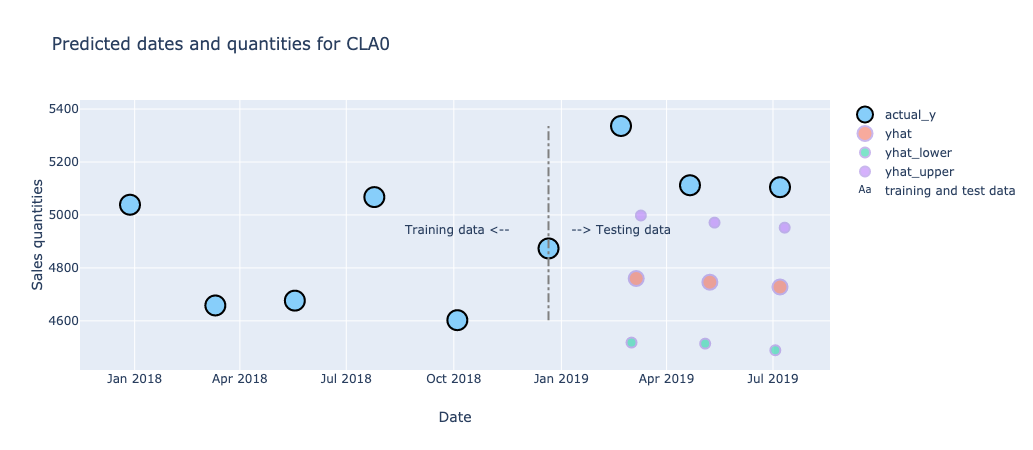

In [51]:
(next_sale_dt_mdl,qty_mdl,full_preds_df)=generate_models_n_preds_df_n_plotly_viz('CLA0')

In [18]:
full_preds_df

,ds,yhat_qty,yhat_lower_qty,yhat_upper_qty,yhat_date,yhat_lower_date,yhat_upper_date,y
0,2017-12-28,4861.637512,4612.511381,5085.050312,NaT,NaT,NaT,5038.619159
1,2018-03-11,4844.114412,4611.561064,5070.556199,2018-03-06,2018-03-02,2018-03-11,4658.195181
2,2018-05-18,4827.791540,4597.850882,5071.433488,2018-05-20,2018-05-16,2018-05-24,4676.433462
3,2018-07-25,4811.468679,4561.261984,5041.277719,2018-07-28,2018-07-24,2018-08-01,5067.550234
4,2018-10-04,4794.425700,4553.800362,5006.322170,2018-10-05,2018-10-01,2018-10-10,4602.628398
5,2018-12-21,4775.702427,4527.770735,5002.680265,2018-12-17,2018-12-12,2018-12-21,4873.462946
6,2019-02-21,4760.819826,4525.319628,4993.200698,2019-03-06,2019-03-02,2019-03-10,5336.037630
7,2019-04-21,4746.657350,4510.053628,4979.886100,2019-05-08,2019-05-03,2019-05-12,5112.239650
8,2019-07-07,4728.174120,4497.202887,4966.713144,2019-07-07,2019-07-03,2019-07-11,5104.938014


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 0.


---------------------------------
--> Now training the "date model"
---------------------------------


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.


-------------------------------------
--> Now training the "quantity model"
-------------------------------------


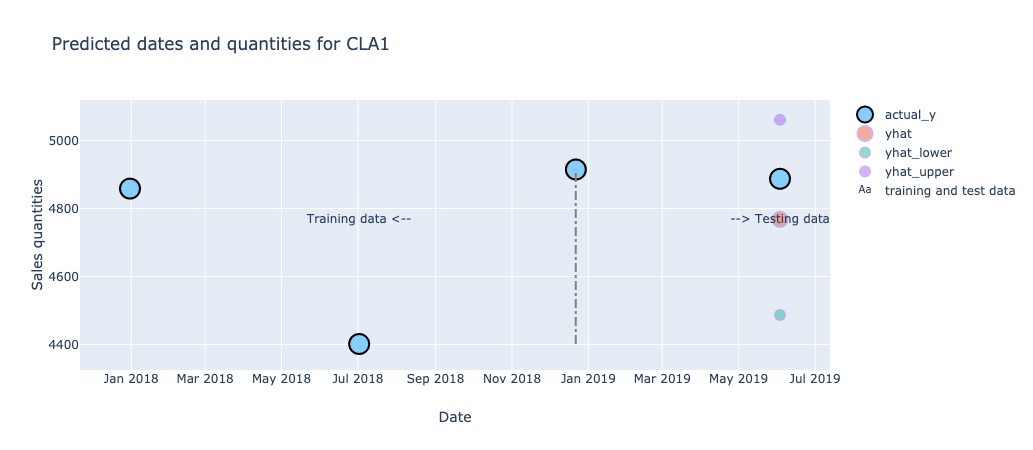

In [55]:
(next_sale_dt_mdl,qty_mdl,full_preds_df)=generate_models_n_preds_df_n_plotly_viz('CLA1')

In [53]:
full_preds_df

,ds,yhat_qty,yhat_lower_qty,yhat_upper_qty,yhat_date,yhat_lower_date,yhat_upper_date,y
0,2017-12-31,4700.041748,4413.771150,4981.415020,NaT,NaT,NaT,NaN
1,2018-07-02,4724.247626,4436.366559,5010.804506,2018-07-02,2018-07-02,2018-07-02,NaN
2,2018-12-22,4747.130778,4464.943541,5052.233814,2018-12-22,2018-12-21,2018-12-22,NaN
3,2019-06-03,4768.691205,4467.925674,5046.724653,2019-06-03,2019-06-03,2019-06-03,NaN


In [14]:
prophet_date_df=sales_clusters_df[sales_clusters_df.product_code=='CLA0'][['noisy_date']].copy()

In [14]:
prophet_date_df

NameError: name 'prophet_date_df' is not defined

In [16]:
idx_split=prophet_date_df['noisy_date'][(prophet_date_df['noisy_date']>=test_year).cumsum()==1].index[0]

In [17]:
idx_split

6

In [18]:
prophet_date_df=generate_next_sale_column(prophet_date_df)

In [19]:
prophet_date_df

,noisy_date,next_sale_date,y
0,2017-12-28,2018-03-11,73
1,2018-03-11,2018-05-18,68
2,2018-05-18,2018-07-25,68
3,2018-07-25,2018-10-04,71
4,2018-10-04,2018-12-21,78
5,2018-12-21,2019-02-21,62
6,2019-02-21,2019-04-21,59
7,2019-04-21,2019-07-07,77


In [20]:
prophet_date_df.rename(index=str, columns={"noisy_date": "ds"},
                 inplace=True)

In [21]:
next_sale_date_model=Prophet()

In [22]:
prophet_date_df[:idx_split]

,ds,next_sale_date,y
0,2017-12-28,2018-03-11,73
1,2018-03-11,2018-05-18,68
2,2018-05-18,2018-07-25,68
3,2018-07-25,2018-10-04,71
4,2018-10-04,2018-12-21,78
5,2018-12-21,2019-02-21,62


In [23]:
next_sale_date_model.fit(prophet_date_df[:idx_split-1])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.


In [24]:
next_sale_date_forecast = next_sale_date_model.predict(pd.DataFrame(prophet_date_df['ds']))

In [25]:
next_sale_date_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2017-12-28,68.995536,64.911463,73.446213
1,2018-03-11,70.346466,65.999622,74.607910
2,2018-05-18,71.604866,67.714939,75.781938
3,2018-07-25,72.863866,68.578554,76.969140
4,2018-10-04,74.178411,70.270874,78.184389
5,2018-12-21,75.622558,71.306913,79.807285
6,2019-02-21,76.770470,72.708860,80.587372
7,2019-04-21,77.862839,73.576752,81.895651


In [26]:
prophet_date_df

,ds,next_sale_date,y
0,2017-12-28,2018-03-11,73
1,2018-03-11,2018-05-18,68
2,2018-05-18,2018-07-25,68
3,2018-07-25,2018-10-04,71
4,2018-10-04,2018-12-21,78
5,2018-12-21,2019-02-21,62
6,2019-02-21,2019-04-21,59
7,2019-04-21,2019-07-07,77


In [27]:
next_sale_date_forecast['actual_y']=prophet_date_df['y'].values

In [28]:
next_sale_date_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper','actual_y']]

,ds,yhat,yhat_lower,yhat_upper,actual_y
0,2017-12-28,68.995536,64.911463,73.446213,73
1,2018-03-11,70.346466,65.999622,74.607910,68
2,2018-05-18,71.604866,67.714939,75.781938,68
3,2018-07-25,72.863866,68.578554,76.969140,71
4,2018-10-04,74.178411,70.270874,78.184389,78
5,2018-12-21,75.622558,71.306913,79.807285,62
6,2019-02-21,76.770470,72.708860,80.587372,59
7,2019-04-21,77.862839,73.576752,81.895651,77


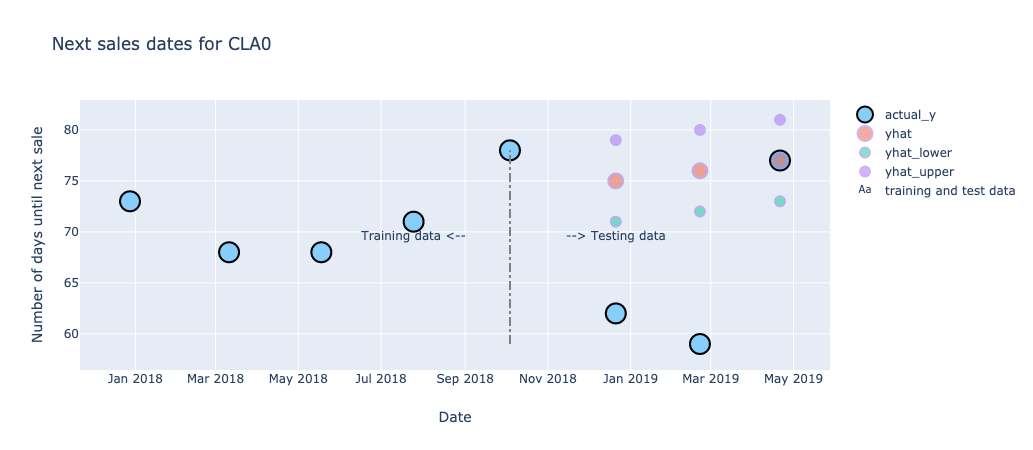

In [72]:
plot_date_preds(next_sale_date_forecast,'CLA0',idx_split)

In [30]:
prophet_qty_df=sales_clusters_df[sales_clusters_df.product_code=='CLA0'][['noisy_date','noisy_quantity']].copy()

In [31]:
prophet_qty_df.rename(index=str, columns={"noisy_date": "ds",
                                      "noisy_quantity": "y"},
                 inplace=True)

In [32]:
prophet_qty_df[:idx_split]

,ds,y
0,2017-12-28,5038.619159
1,2018-03-11,4658.195181
2,2018-05-18,4676.433462
3,2018-07-25,5067.550234
4,2018-10-04,4602.628398
5,2018-12-21,4873.462946


In [33]:
qty_model=Prophet()

In [34]:
qty_model.fit(prophet_qty_df[:idx_split])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.


In [35]:
qty_forecast = qty_model.predict(pd.DataFrame(prophet_qty_df['ds']))

In [36]:
qty_predictions=qty_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][idx_split:]

In [37]:
for col in qty_predictions.columns[1:]:
    qty_predictions.rename(index=str,
                                       columns={col: col+'_qty'},
                                      inplace=True)

In [38]:
qty_predictions

,ds,yhat_qty,yhat_lower_qty,yhat_upper_qty
6,2019-02-21,4760.819826,4538.698801,4992.133304
7,2019-04-21,4746.657350,4507.008275,4988.104625
8,2019-07-07,4728.174120,4503.353008,4989.463476


In [39]:
next_sale_dates_predictions=next_sale_date_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][idx_split-1:]

In [40]:
next_sale_dates_predictions

,ds,yhat,yhat_lower,yhat_upper
5,2018-12-21,75.622558,71.306913,79.807285
6,2019-02-21,76.770470,72.708860,80.587372
7,2019-04-21,77.862839,73.576752,81.895651


In [41]:
next_sale_dates_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 5 to 7
Data columns (total 4 columns):
ds            3 non-null datetime64[ns]
yhat          3 non-null float64
yhat_lower    3 non-null float64
yhat_upper    3 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 184.0 bytes


In [42]:
next_sale_dates_predictions.columns[1:]

Index(['yhat', 'yhat_lower', 'yhat_upper'], dtype='object')

In [43]:
for col in next_sale_dates_predictions.columns[1:]:
    next_sale_dates_predictions[col]=[pd.Timedelta(str(int(t))+' days') for t in next_sale_dates_predictions[col].values]
    next_sale_dates_predictions[col]=next_sale_dates_predictions['ds']+next_sale_dates_predictions[col]
    next_sale_dates_predictions.rename(index=str,
                                       columns={col: col+'_date'},
                                      inplace=True)

In [44]:
next_sale_dates_predictions

,ds,yhat_date,yhat_lower_date,yhat_upper_date
5,2018-12-21,2019-03-06,2019-03-02,2019-03-10
6,2019-02-21,2019-05-08,2019-05-04,2019-05-12
7,2019-04-21,2019-07-07,2019-07-03,2019-07-11


In [45]:
full_predictions_df=qty_predictions.copy()

In [46]:
for col in next_sale_dates_predictions.columns[1:]:
    full_predictions_df[col]=next_sale_dates_predictions[col].values

In [47]:
full_predictions_df

,ds,yhat_qty,yhat_lower_qty,yhat_upper_qty,yhat_date,yhat_lower_date,yhat_upper_date
6,2019-02-21,4760.819826,4538.698801,4992.133304,2019-03-06,2019-03-02,2019-03-10
7,2019-04-21,4746.657350,4507.008275,4988.104625,2019-05-08,2019-05-04,2019-05-12
8,2019-07-07,4728.174120,4503.353008,4989.463476,2019-07-07,2019-07-03,2019-07-11


In [48]:
prophet_qty_df

,ds,y
0,2017-12-28,5038.619159
1,2018-03-11,4658.195181
2,2018-05-18,4676.433462
3,2018-07-25,5067.550234
4,2018-10-04,4602.628398
5,2018-12-21,4873.462946
6,2019-02-21,5336.037630
7,2019-04-21,5112.239650
8,2019-07-07,5104.938014


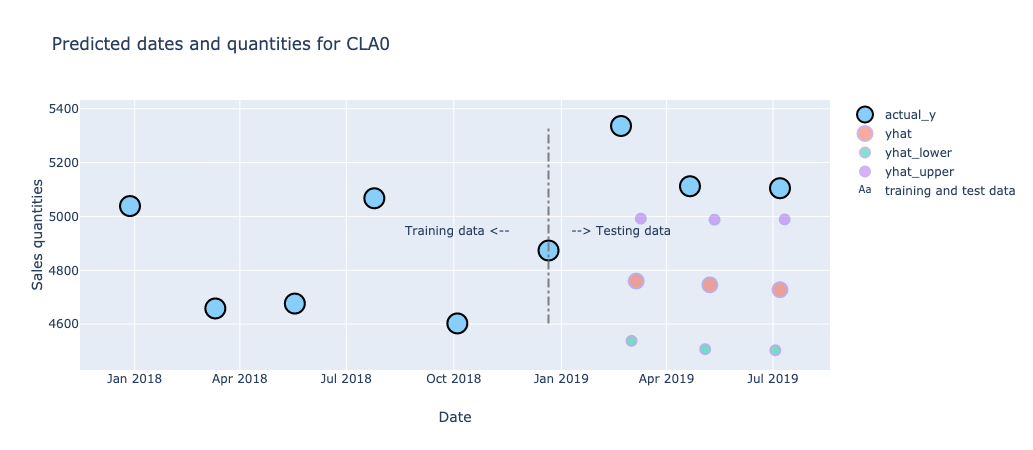

In [80]:
plot_full_preds(prophet_qty_df,
              full_predictions_df,
              'CLA0',
              idx_split)

In [87]:
# Select the interesting columns and the testing year only
qty_predictions=qty_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

for col in qty_predictions.columns[1:]:
    qty_predictions.rename(index=str,
                            columns={col: col+'_qty'},
                            inplace=True)

next_sale_dates_predictions=next_sale_date_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

for col in next_sale_dates_predictions.columns[1:]:
    next_sale_dates_predictions[col]=[pd.Timedelta(str(int(t))+' days') for t in next_sale_dates_predictions[col].values]
    next_sale_dates_predictions[col]=next_sale_dates_predictions['ds']+next_sale_dates_predictions[col]
    next_sale_dates_predictions.rename(index=str,
                                        columns={col: col+'_date'},
                                        inplace=True)

full_predictions_df=qty_predictions.copy()

for col in next_sale_dates_predictions.columns[1:]:
    full_predictions_df[col][1:]=next_sale_dates_predictions[col].values

full_predictions_df['y']=prophet_qty_df['y']

KeyError: 'yhat_date'

In [ ]:
full

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.


---------------------------------
--> Now training the "date model"
---------------------------------


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.


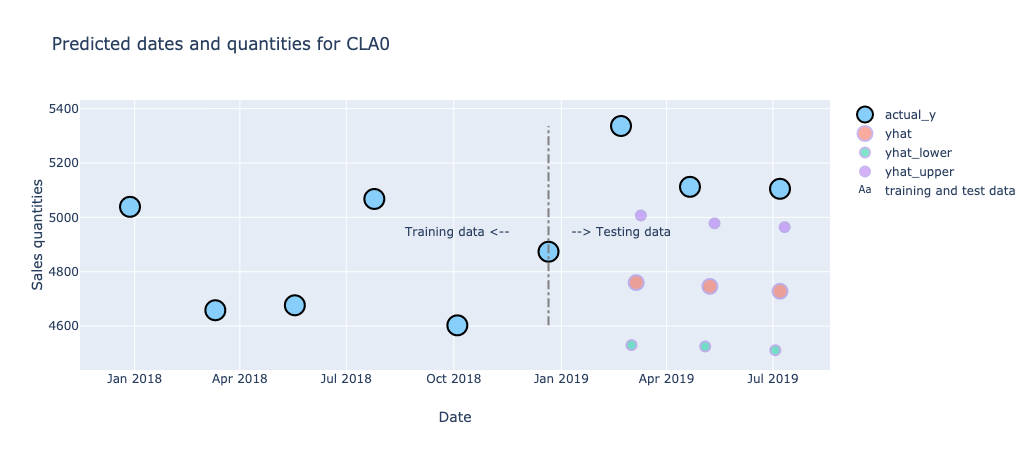

In [85]:
(next_sale_dt_mdl,qty_mdl,full_preds_df,prophet_df)=generate_models_n_preds_df_n_plotly_viz('CLA0')

In [77]:
help(generate_models_n_preds_df_n_plotly_viz)

Help on function generate_models_n_preds_df_n_plotly_viz in module __main__:

generate_models_n_preds_df_n_plotly_viz(client)
    This function aims to take a client and output:
    -  1 date model
    -  1 qty model
    -  1 predictions df
    -  1 plotly graph of the predictions



# Clusters analysis

In [ ]:
import plotly.graph_objects as go

In [ ]:
sales_clusters_df.head()

In [ ]:
sales_clusters_df[sales_clusters_df['Cluster']==0][['noisy_date','noisy_quantity']].info()

In [ ]:
fig = go.Figure()

for cluster in sales_clusters_df.Cluster.value_counts().index.values:
    
    fig.add_trace(go.Scatter(x=sales_clusters_df[sales_clusters_df['Cluster']==cluster]['noisy_date'].astype(str).values,
                             y=sales_clusters_df[sales_clusters_df['Cluster']==cluster]['noisy_quantity'].values,
                        mode='markers',
                        name='Cluster '+str(cluster)))

# Edit the layout
fig.update_layout(title='Labels Sales per cluster',
                   xaxis_title='Date',
                   yaxis_title='Quantities')


fig.show()

# Cluster #0 predictions

In [ ]:
cluster_prophet_df=sales_clusters_df[sales_clusters_df['Cluster']==0][['noisy_date','noisy_quantity']].copy()

In [ ]:
cluster_prophet_df.rename(index=str, columns={"noisy_date": "ds",
                                      "noisy_quantity": "y"},
                 inplace=True)

In [ ]:
cluster_prophet_df.describe()

In [ ]:
cluster_prophet_df=cluster_prophet_df.sort_values('ds')
cluster_prophet_df['cap'] = 8000
cluster_prophet_df['floor'] = 1300

In [ ]:
cluster_model=Prophet(growth='logistic',
                      changepoint_prior_scale= 0.001)

In [ ]:
cluster_model.fit(cluster_prophet_df[:25])

In [ ]:
cluster_prophet_df.info()

In [ ]:
cluster_forecast = cluster_model.predict(pd.DataFrame(cluster_prophet_df[['ds','cap','floor']]))

In [ ]:
cluster_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
cluster_prophet_df.tail()

In [ ]:
cluster_prophet_df[:25]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig1 = cluster_model.plot(cluster_forecast)
plt.scatter(cluster_prophet_df['ds'],
           cluster_prophet_df['y'],color='g')